In [115]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
print(tf.__version__)

1.14.0


In [89]:
def build_conv_model():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(35, (3,),
        activation='relu',strides=1,input_shape=[waveNumd+1,1]),
    layers.Conv1D(30, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(20, (3,),
        activation='relu'),
    layers.Conv1D(20, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances



def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    return 0

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

In [90]:
model = build_conv_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 39, 35)            140       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 37, 30)            3180      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 18, 30)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 16, 20)            1820      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 13, 20)            1620      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 6, 20)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 120)              

In [93]:
sizeX = 968
sizeY = 968

waveCut0 = 25
waveCut1 = 65
waveNumd = waveCut1-waveCut0+1

waveNum  = 76

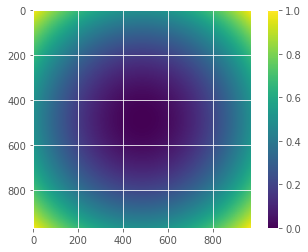

(89, 968, 968)


In [94]:
indices = radial_dist(sizeX,sizeY)

indices = indices / max(indices.flatten())
        
im1 = plt.imshow(np.reshape(indices,(sizeX,sizeY)))
plt.colorbar(im1)
plt.show() 

spec1 = (load_spectral_profiles('','even_ca_1fp.fits'))
waveNum  = (spec1.shape)[0]
spec1 = np.reshape(spec1,(waveNum,sizeX*sizeY))
spec1 = np.swapaxes(spec1,0,1)

spec2 = (load_spectral_profiles('','even_ca_2fp.fits'))
print(spec2.shape)
spec2 = np.reshape(spec2,(waveNum,sizeX*sizeY))
spec2 = np.swapaxes(spec2,0,1)

In [106]:
train_set1 = spec1[:,waveCut0:waveCut1]
truth_set1 = spec2[:,waveCut0:waveCut1]
print(train_set1.shape)
cont_train = np.mean(train_set1[:,2]+train_set1[:,-2])
cont_truth = np.mean(truth_set1[:,2]+truth_set1[:,-2])

'''
for ii in range(train_set1.shape[0]):
    cont_12     =  0.5*(train_set1[ii,2]+train_set1[ii,-2])
    if np.isnan(cont_12) == True:
        print(np.isnan(cont_12))
    #print(cont_12)
    train_set1[ii,:] = train_set1[ii,:] / cont_12

for ii in range(truth_set1.shape[0]):
    cont_12     =  0.5*(truth_set1[ii,2]+truth_set1[ii,-2])
    if np.isnan(cont_12) == True:
                print(np.isnan(cont_12))
    truth_set1[ii,:] = truth_set1[ii,:] / cont_12
'''

for ii in range(train_set1.shape[0]):
    train_set1[ii,:] = train_set1[ii,:]/cont_train
    truth_set1[ii,:] = truth_set1[ii,:]/cont_truth
    

#plt.plot(truth_set1[2000,:],'r.--')
#plt.plot(train_set1[2000,:],'b.--')
#plt.show()


train_set = np.zeros((sizeX*sizeY,1,(waveNumd)))
truth_set = np.zeros((sizeX*sizeY,(waveNumd)))
print(train_set.shape)
train_set[:,0,0:(waveNumd-1)] = train_set1
train_set[:,0,(waveNumd-1)]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set,1,2))
print(train_set.shape)
#truth_set = (np.swapaxes(truth_set,0,1))
#print(truth_set.shape)

(937024, 40)
(937024, 1, 41)
(937024, 41, 1)


In [107]:
EPOCHS = 10
#print(train_set)
history = model.fit((train_set)[90000:-90000,:,:],truth_set[90000:-90000,:],
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

Train on 643470 samples, validate on 113554 samples
Epoch 1/10
643470/643470 [==============================] - 97s 151us/sample - loss: 9.9564e-04 - mean_absolute_error: 0.0210 - mean_squared_error: 9.9564e-04 - val_loss: 7.1692e-04 - val_mean_absolute_error: 0.0198 - val_mean_squared_error: 7.1692e-04
Epoch 2/10
643470/643470 [==============================] - 87s 135us/sample - loss: 7.0390e-04 - mean_absolute_error: 0.0196 - mean_squared_error: 7.0390e-04 - val_loss: 6.9704e-04 - val_mean_absolute_error: 0.0193 - val_mean_squared_error: 6.9704e-04
Epoch 3/10
643470/643470 [==============================] - 97s 150us/sample - loss: 6.9197e-04 - mean_absolute_error: 0.0194 - mean_squared_error: 6.9197e-04 - val_loss: 6.9313e-04 - val_mean_absolute_error: 0.0193 - val_mean_squared_error: 6.9313e-04
Epoch 4/10
305856/643470 [=============>................] - ETA: 45s - loss: 6.8808e-04 - mean_absolute_error: 0.0194 - mean_squared_error: 6.8808e-04

KeyboardInterrupt: 

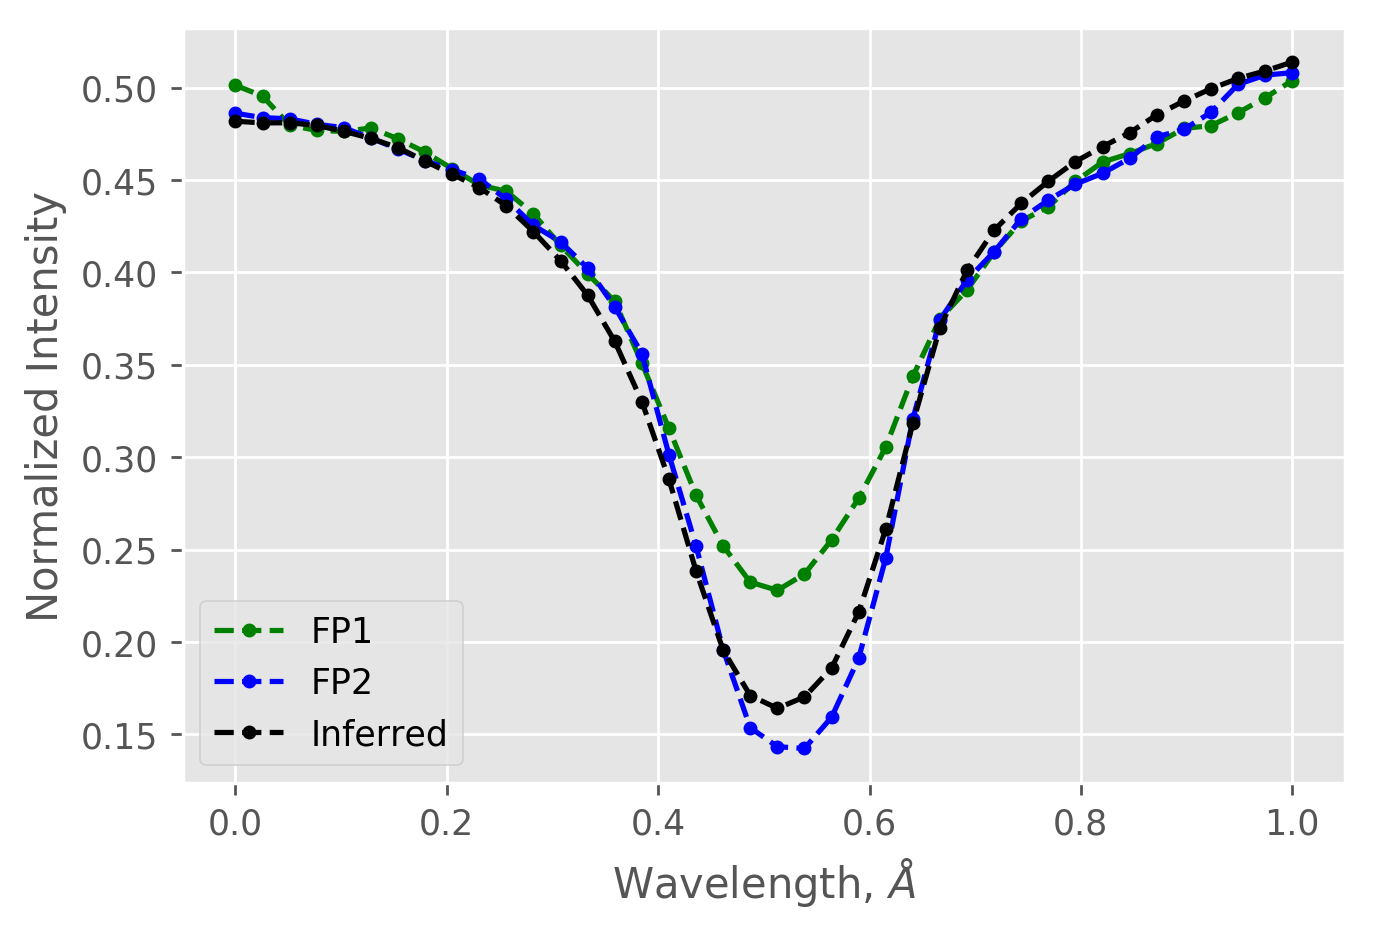

0

In [112]:
prevNum  = 382500
delta    = 1000


#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

res = model.predict(train_set[prevNum:prevNum+delta,:,:])

wavescale = np.linspace(0,1,num=waveNumd-1)
plot_spec_profile_comparison(wavescale,train_set[prevNum,:-1,0],truth_set[prevNum,:],res[0,:])

In [11]:
train_set[:,0,50]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set,1,2))
print(train_set.shape)
#truth_set = (np.swapaxes(truth_set,1,2))
print(truth_set.shape)

IndexError: index 50 is out of bounds for axis 2 with size 1

In [ ]:
im1 = np.reshape(train_set[:,0,0],(968,968))
im = plt.imshow(im1)
plt.colorbar(im)
plt.show()

The elapsed time for 1M Pixel inversion is:  42.97 seconds


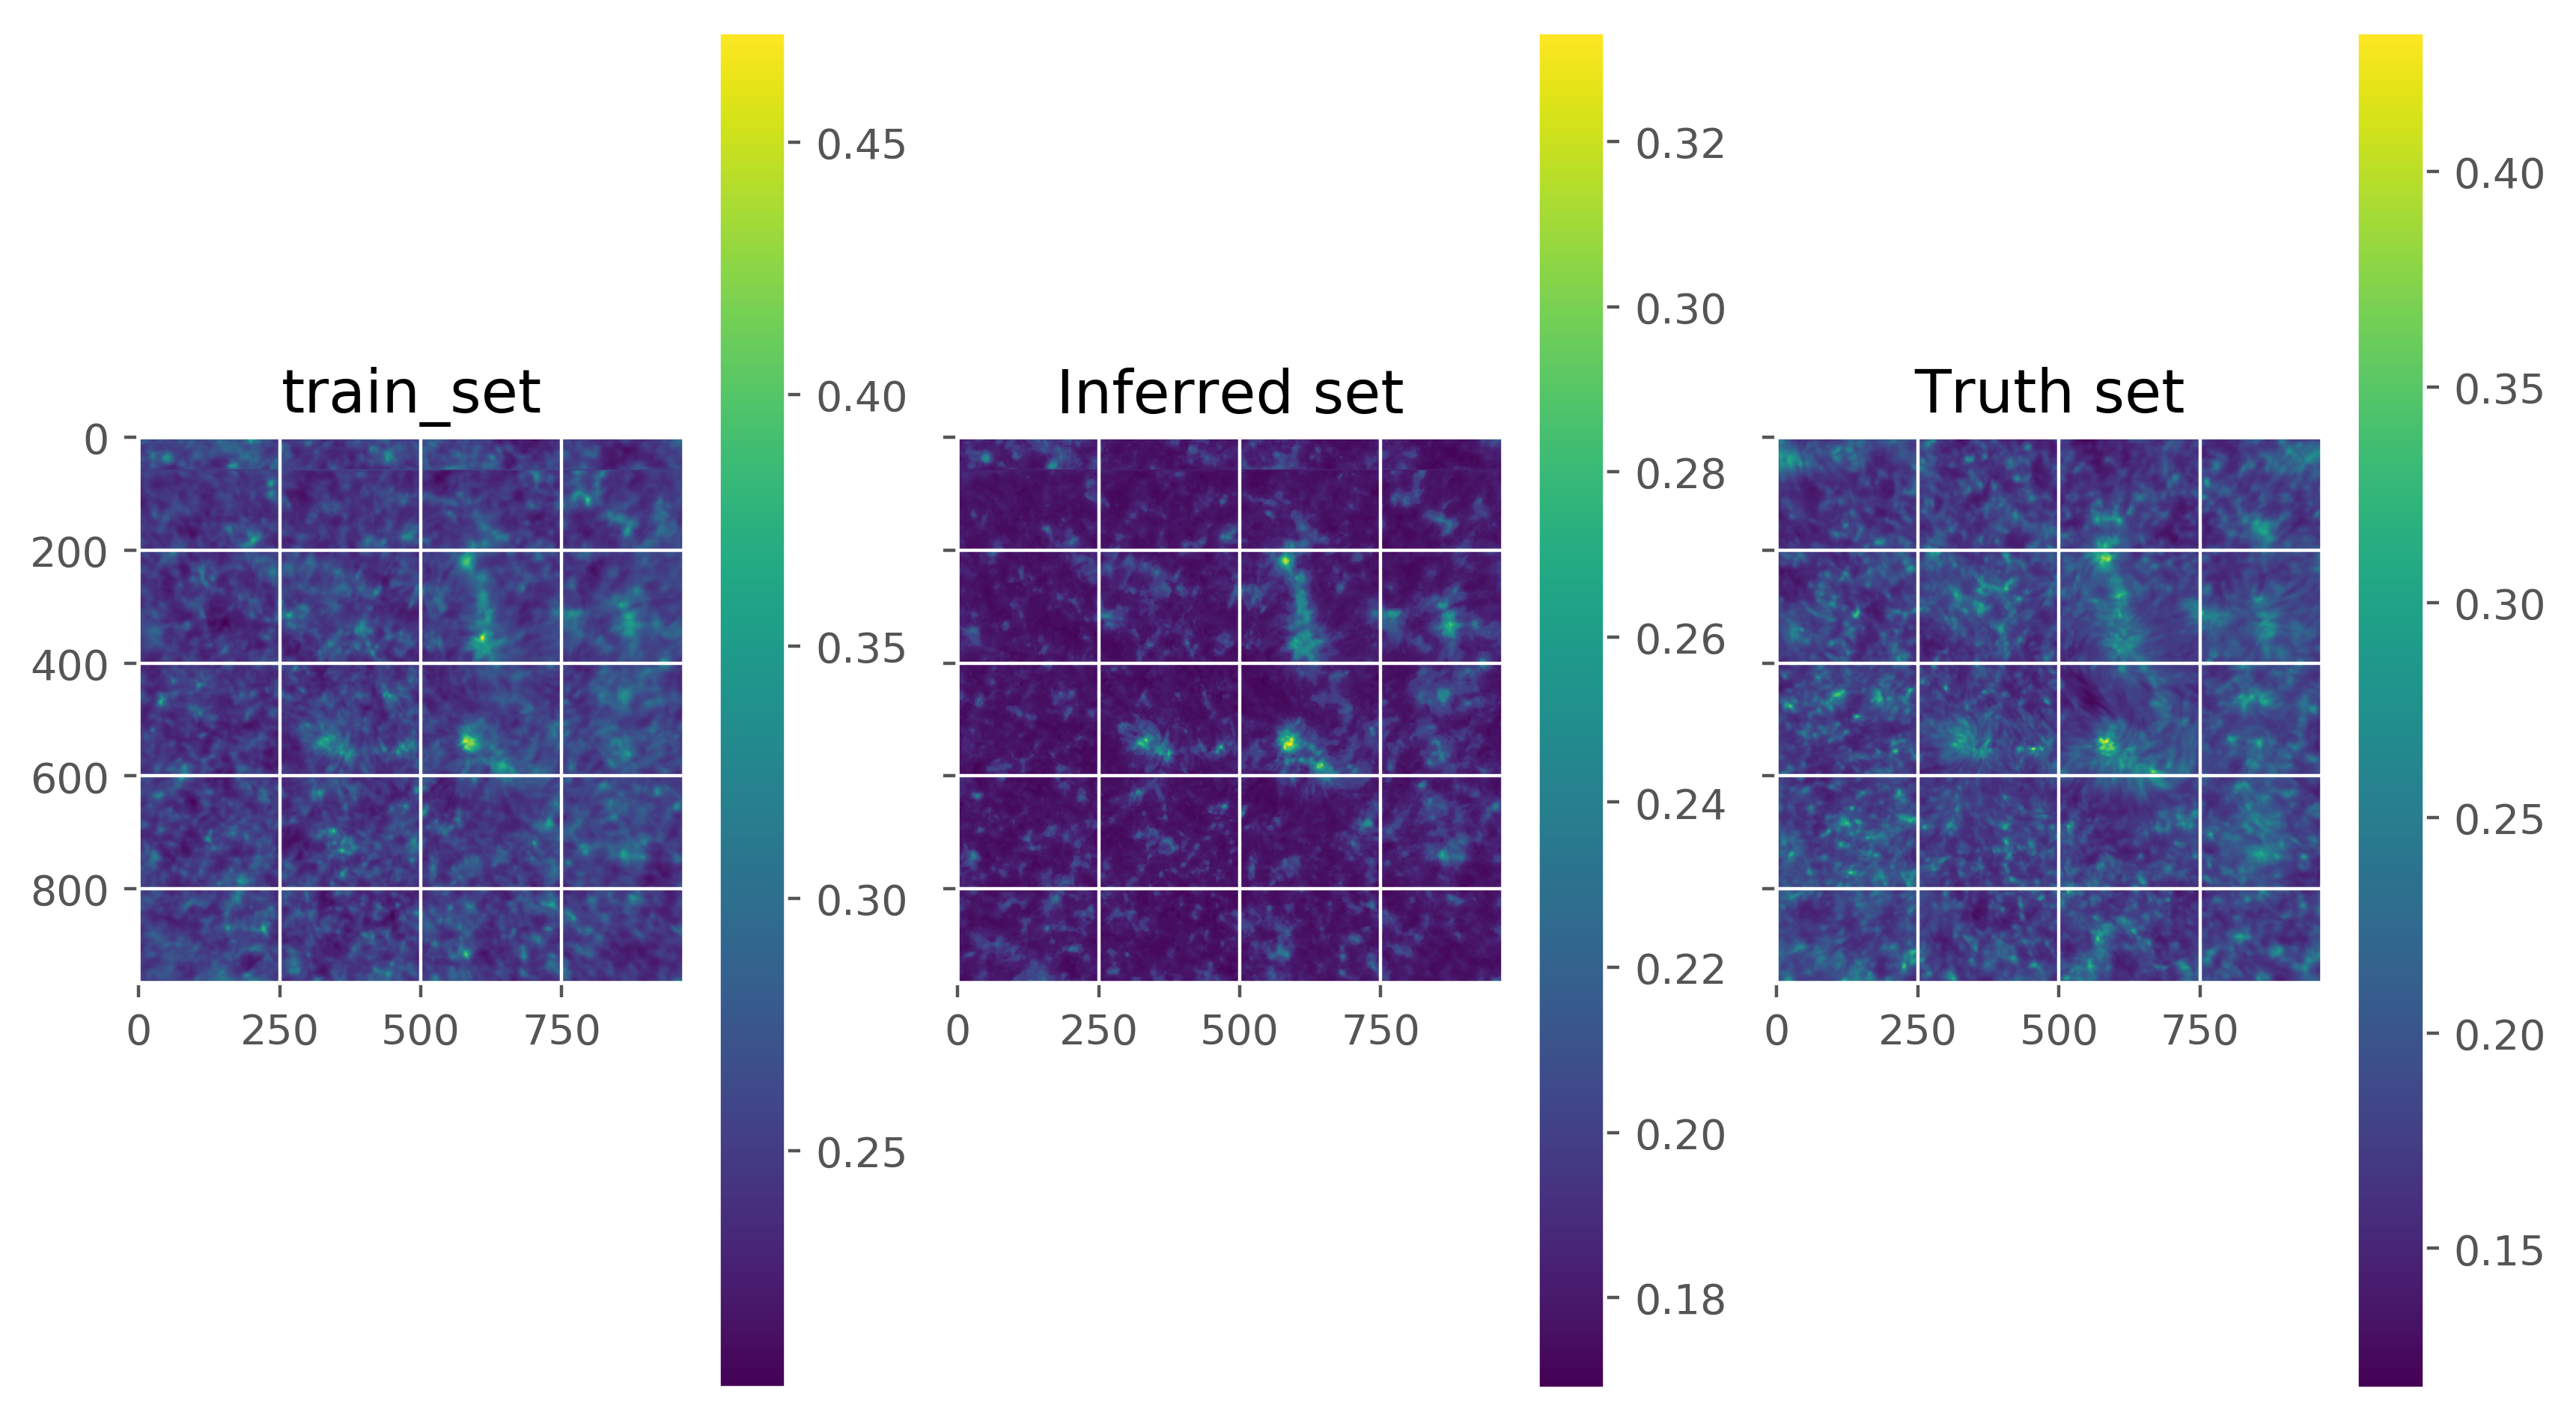

In [121]:
start = time.process_time()
im = model.predict(train_set[:,:,:])
print("The elapsed time for 1M Pixel inversion is: %6.2f seconds"%(time.process_time() - start))

dim1 = 18
dim2 = 22

figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(400)
figure.set_size_inches(10,6)
ax[0].set_title('train_set')
im0 = ax[0].imshow(np.reshape(np.mean(train_set[:,dim1:dim2,0],axis=1),(sizeX,sizeY)))
figure.colorbar(im0, ax=ax[0])
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.mean(im[:,dim1:dim2],axis=1)),(sizeX,sizeY)))
figure.colorbar(im1, ax=ax[1])

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.mean(truth_set[:,dim1:dim2],axis=1),(sizeX,sizeY)))
figure.colorbar(im2, ax=ax[2])
plt.show() 

[[0.486807   0.48523474 0.48524833 ... 0.5078686  0.5119044  0.51629263]
 [0.48718804 0.48559964 0.48563892 ... 0.50811905 0.5120914  0.516438  ]
 [0.48701662 0.48534042 0.48542354 ... 0.5078184  0.51172805 0.5160509 ]
 ...
 [0.4824903  0.48068276 0.48069867 ... 0.5041624  0.5083726  0.5131014 ]
 [0.48580152 0.48452157 0.48435867 ... 0.507424   0.511532   0.51593894]
 [0.48663664 0.48516095 0.4852019  ... 0.5080378  0.51209885 0.51658356]]


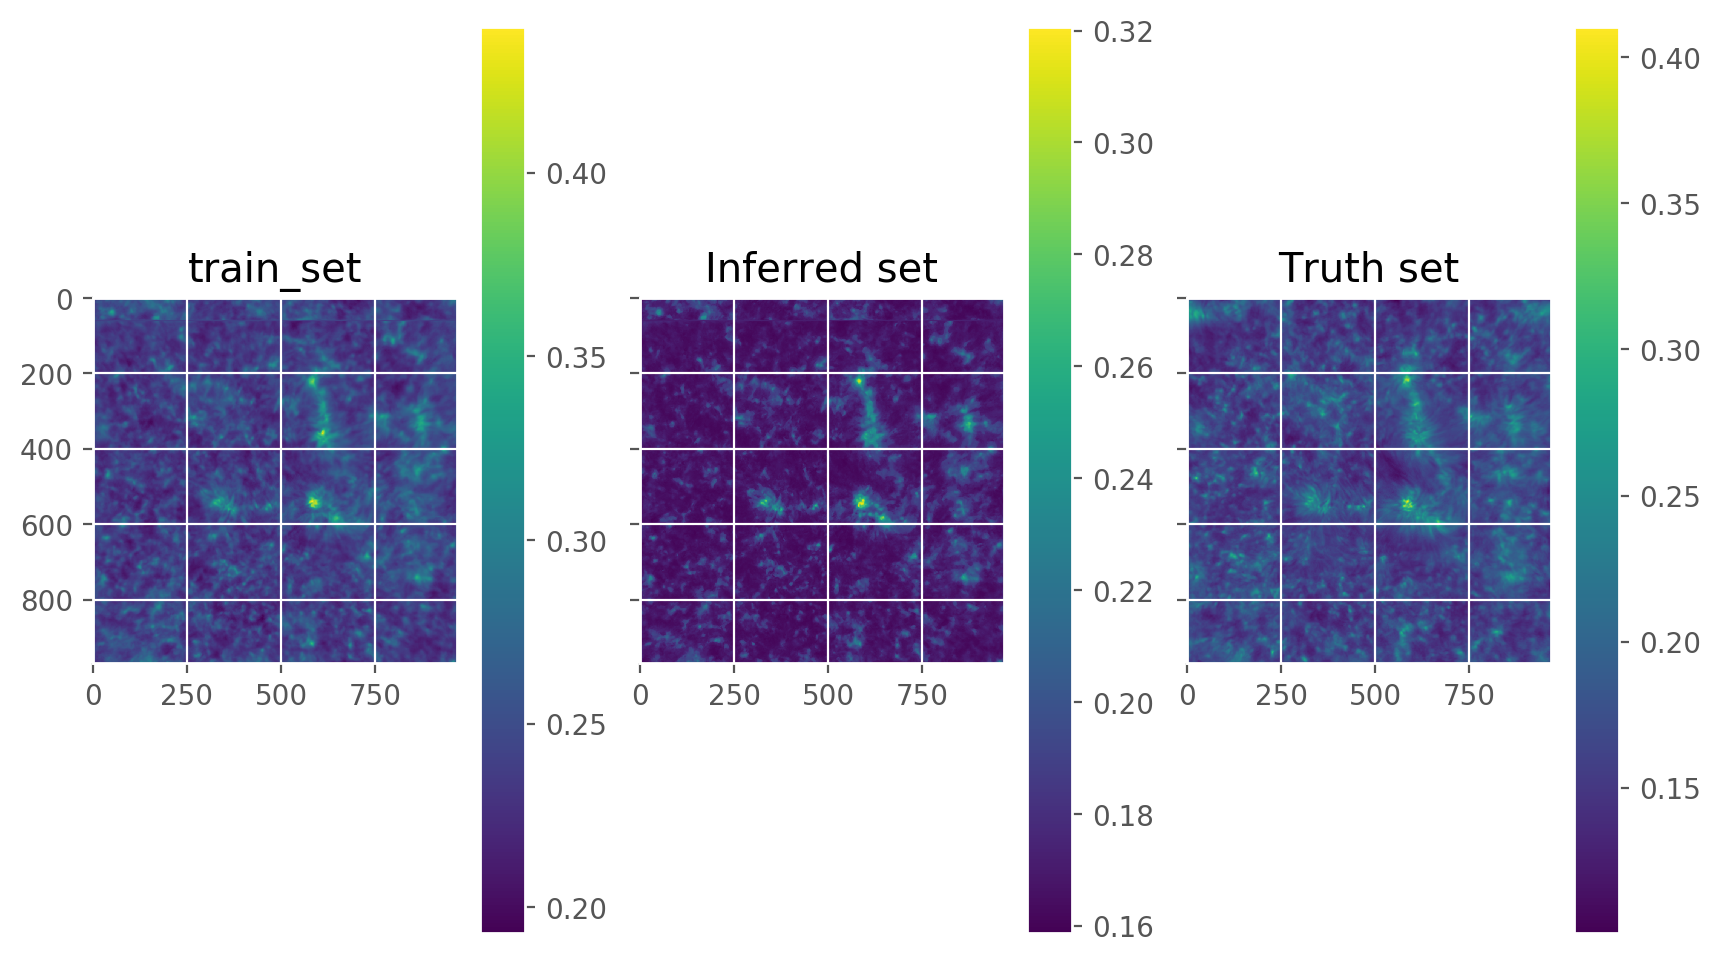

In [117]:
#im = model.predict(train_set[:,:,:])
print(im)

figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(200)
figure.set_size_inches(10,6)
ax[0].set_title('train_set')
im0 = ax[0].imshow(np.reshape(np.amin(train_set[:,5:-5,0],axis=1),(sizeX,sizeY)))
figure.colorbar(im0, ax=ax[0])
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.amin(im,axis=1)),(sizeX,sizeY)))
figure.colorbar(im1, ax=ax[1])

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.amin(truth_set,axis=1),(sizeX,sizeY)))
figure.colorbar(im2, ax=ax[2])
plt.show() 

In [527]:
im[:,30

(937024,)